In [2]:
from fastai.vision.all import *

path = untar_data(URLs.PASCAL_2007)

In [4]:
df = pd.read_csv(path / 'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [5]:
dblock = DataBlock()
dsets = dblock.datasets(df)

dsets.train[0]

(fname       009466.jpg
 labels           chair
 is_valid         False
 Name: 4756, dtype: object,
 fname       009466.jpg
 labels           chair
 is_valid         False
 Name: 4756, dtype: object)

In [6]:
dblock = DataBlock(
    get_x=lambda r: r['fname'],
    get_y=lambda r: r['labels']
)
dsets = dblock.datasets(df)
dsets.train[0]

('008413.jpg', 'person chair')

In [7]:
def get_x(r):
    return path / 'train' / r['fname']


def get_y(r):
    return r['labels'].split(' ')


dblock = DataBlock(
    get_x=get_x,
    get_y=get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(Path('C:/Users/Admin/.fastai/data/pascal_2007/train/003876.jpg'),
 ['aeroplane'])

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_x,
    get_y=get_y
)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
                      0., 0., 0., 0., 0.]))

In [15]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#4) ['bus','car','motorbike','person']

In [16]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y
)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

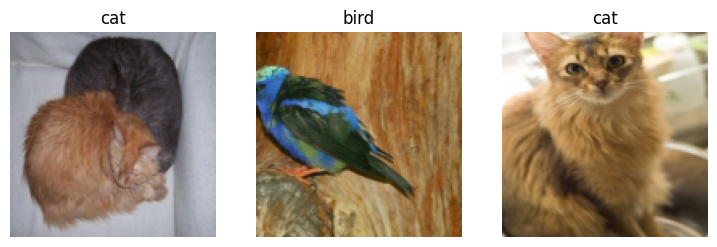

In [25]:
dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x=get_x,
    get_y=get_y,
    item_tfms=RandomResizedCrop(128, min_scale=0.35)
)

dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

## 看看你的batch！
Knowing how to manually get a mini-batch and pass it into a
model, and look at the activations and loss, is really important for
debugging your model. It is also very helpful for learning, so that
you can see exactly what is going on.

In [29]:
learn = vision_learner(dls, resnet18)
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [30]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()



TensorImage([-0.6390,  0.2944, -1.9009,  0.8508, -1.5778, -0.2673,  0.5702,
             -1.5554, -0.2353,  0.7730, -1.8384, -0.7478, -0.8590, -0.0349,
              2.2814,  1.2612, -0.8812,  3.0756, -1.5929,  0.9731],
            grad_fn=<AliasBackward0>)

In [36]:
# 等价于pytorch的BCEWithLogitsLoss
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, Tensor(y))
loss

TensorImage(1.0683, grad_fn=<AliasBackward0>)

In [37]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp>thresh) == targ.bool()).float().mean()



In [38]:
learn = vision_learner(
    dls,
    resnet50,
    metrics=partial(accuracy_multi, thresh=0.2)
)
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:10<00:00, 9.92MB/s]


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.957535,0.705005,0.227131,01:17
1,0.834381,0.555695,0.285996,01:05
2,0.609125,0.193929,0.825737,01:06
3,0.358656,0.116319,0.945359,01:07


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.126822,0.103278,0.950677,01:22


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001BDFA9827D0>>
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\envs\hust\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

In [ ]:
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

In [ ]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

# 回归

In [39]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01.obj'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/02'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/02.obj'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/03'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/03.obj'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/04'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/04.obj'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/05'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/05.obj')...]

In [40]:
(path/'01').ls()

(#1000) [Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/depth.cal'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [41]:
img_files = get_image_files(path)
def img2pose(x):
    return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('C:/Users/Admin/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

In [42]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

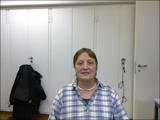

In [63]:
im.to_thumb(160)

In [67]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [69]:
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

get_ctr(img_files[0])

tensor([350.4915, 262.9643])

In [70]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)


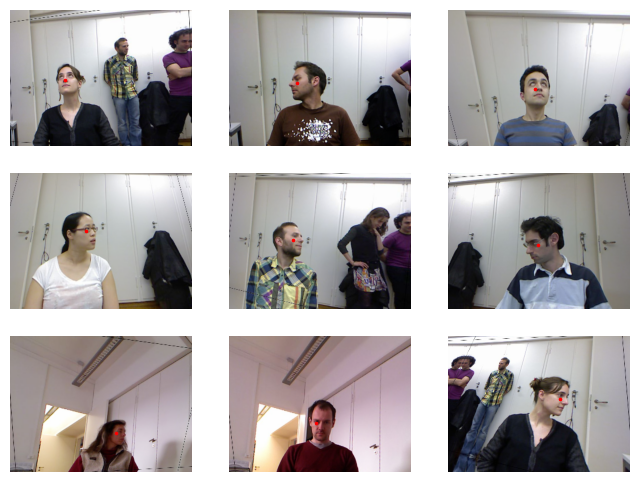

In [71]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [73]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [76]:
learn = vision_learner(
    dls,
    resnet18,
    y_range=(-1,1)
)


In [78]:
def sigmoid_range(x, lo, hi):
    return torch.sigmoid(x)* (hi-lo) + lo + lo

In [79]:
dls.loss_func

FlattenedLoss of MSELoss()

In [80]:
learn.lr_find()


KeyboardInterrupt



In [ ]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

In [ ]:
learn.show_results(ds_idx=1, max_n=3, figsize=(6,8))